In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
import scipy.sparse as sps
%matplotlib inline  
%load_ext Cython

from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

In [2]:
# data_train_path="/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv"
# data_target_user_path="/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv"
data_train_path="data_train.csv"
data_target_user_path="data_target_users_test.csv"
data_train = pd.read_csv(data_train_path)
data_target = pd.read_csv(data_target_user_path)

In [3]:
URM_all =  data_train.pivot(index='row', columns='col', values='data').fillna(0)
item_map = {i : item for i, item in enumerate(URM_all.columns)}
user_map = {i : user for i, user in enumerate(data_target["user_id"])}
item_map_inv = {item : i for i, item in item_map.items()}
user_map_inv = {user : i for i, user in user_map.items()}
missing_index = [x for x in range(1,13025) if x not in URM_all.index.tolist()]
add_urm = pd.DataFrame(index = missing_index, columns = URM_all.columns).fillna(0)
URM_all = pd.concat([URM_all, add_urm]).sort_index()
del add_urm
del missing_index
#data_target["user_id"] = data_target["user_id"]
URM_all = URM_all.to_numpy()
urm_sparse = sps.csr_matrix(URM_all)
urm_sparse

<13024x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [4]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(urm_sparse, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2958 (22.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [5]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
import pandas as pd
from scipy.stats import loguniform

hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "MAP"])
hyperparameter_search_rnd["k"] = loguniform.rvs(200, 500, size=21).astype(int)
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="k")

for index in hyperparameter_search_rnd.index:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=hyperparameter_search_rnd.loc[index,"k"])
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    hyperparameter_search_rnd.loc[index,"MAP"] = result_df.loc[10]["MAP"]

UserKNNCFRecommender: URM Detected 842 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 324 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 2358.17 column/sec. Elapsed time 5.52 sec
EvaluatorHoldout: Processed 10066 (100.0%) in 6.44 sec. Users per second: 1564
UserKNNCFRecommender: URM Detected 842 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 324 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 2360.91 column/sec. Elapsed time 5.52 sec
EvaluatorHoldout: Processed 10066 (100.0%) in 6.65 sec. Users per second: 1513
UserKNNCFRecommender: URM Detected 842 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 324 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 2287.67 column/sec. 

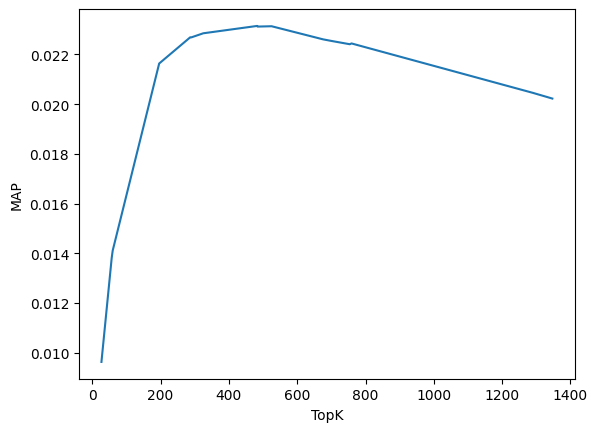

In [6]:
pyplot.plot(hyperparameter_search_rnd["k"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

In [7]:
best_k_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_k_value

k          483
MAP    0.02315
Name: 8, dtype: object

In [8]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "shrink", "MAP"])
hyperparameter_search_rnd["shrink"] = loguniform.rvs(0.1, 100, size=11).astype(int)
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="shrink")
hyperparameter_search_rnd["k"] = best_k_value["k"]

for index in hyperparameter_search_rnd.index:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=hyperparameter_search_rnd.loc[index,"shrink"], 
                    topK=hyperparameter_search_rnd.loc[index,"k"])
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    hyperparameter_search_rnd.loc[index, "MAP"] = result_df.loc[10]["MAP"]

UserKNNCFRecommender: URM Detected 842 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 324 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python


Similarity column 13024 (100.0%), 1322.13 column/sec. Elapsed time 9.85 sec
EvaluatorHoldout: Processed 10066 (100.0%) in 8.87 sec. Users per second: 1135
UserKNNCFRecommender: URM Detected 842 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 324 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1257.93 column/sec. Elapsed time 10.35 sec
EvaluatorHoldout: Processed 10066 (100.0%) in 9.27 sec. Users per second: 1085
UserKNNCFRecommender: URM Detected 842 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 324 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1244.32 column/sec. Elapsed time 10.47 sec
EvaluatorHoldout: Processed 10066 (100.0%) in 8.96 sec. Users per second: 1123
UserKNNCFRecommender: URM Detected 842 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected

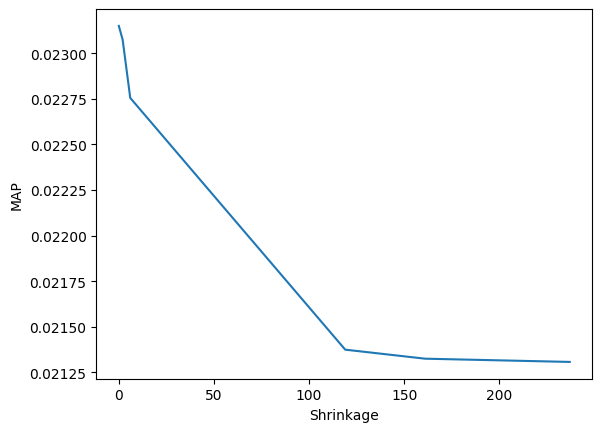

In [9]:
pyplot.plot(hyperparameter_search_rnd["shrink"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

In [29]:
best_parameters_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_parameters_value

k             483
shrink          0
MAP       0.02315
Name: 5, dtype: object

In [27]:


import time
recommender = UserKNNCFRecommender(urm_sparse)
recommender.fit(shrink=best_parameters_value["shrink"], topK=best_parameters_value["k"])
n_users_to_test = len(data_target["user_id"])
suggestions = pd.DataFrame(columns = ["user_id", "item_list", "item_scores"])
start_time = time.time()

for user_id in (data_target["user_id"]-1):
    suggestion, suggestion_values = recommender.recommend(user_id, cutoff=10, return_scores=True)
    suggestions.loc[len(suggestions)] = [user_id+1, " ".join([str(item_map[x]) for x in suggestion]), " ".join([str(x) for x in np.flip(np.sort(suggestion_values))[0][:10]])]
print(np.sort(suggestion_values)[::-1]) 
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1130.60 column/sec. Elapsed time 11.52 sec
[[     -inf      -inf      -inf ... 3.5094543 3.6673088 4.180811 ]]
Reasonable implementation speed is 458.80 usr/sec


In [28]:
suggestions

,user_id,item_list,item_values
0,1,101 36 403 506 515 977 1546 869 3 29,4.824763 4.654411 2.349728 2.2210774 1.979832 ...
1,2,2 5 3 6 47 28 4 8 50 11,8.395588 8.202101 7.026572 6.9536204 6.8721404...
2,3,59 259 584 536 5 9 648 956 2 7,4.8280478 2.7180092 2.3532782 2.2246647 2.1673...
3,4,28 50 1 2 5 6 3 145 4 9,18.848686 14.856761 11.68789 10.570448 10.3960...
4,5,4 51 131 6 135 44 77 26 8 25,1.6506774 1.5346771 1.4078486 1.2826381 1.2334...
...,...,...,...
10877,13020,506 161 34 337 6450 403 105 51 59 159,2.7719536 2.5250084 2.4659104 2.1328647 2.0162...
10878,13021,133 139 1 254 8 36 3 2 593 32,7.8508945 5.044798 4.5949783 4.5900035 4.45261...
10879,13022,1411 1668 809 1446 1674 3 34 77 53 66,2.8705804 2.545662 2.38413 2.3226738 2.2530046...
10880,13023,129 32 3 242 82 89 2 308 7 313,7.0301743 6.1074133 5.426261 4.9310184 4.92618...
